<a href="https://colab.research.google.com/github/pari1jay/6_Customer-sentiment-Analysis/blob/main/Customer_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Connect Colab with Google Drive

# Mining Consumer Voices: A Sentiment Analysis of Financial Complaints Using NLP

I have here worked on a sentiment analysis project using real-world complaint data from the Consumer Financial Protection Bureau (CFPB) available on kaggle. Through this project I aim to uncover insights from complaint narratives and classify customer sentiment using natural language processing (NLP) techniques.

The customer sentiment metric helps organizations to pinpoint customer opinions and feelings about their business, products or services. It allows companies to see if their audience has a positive, negative or neutral view of their experiences. It can also help customers choose companies best for a particular product.

In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [2]:
import pandas as pd # data manipulation
import matplotlib.pyplot as plt #plotting
from wordcloud import WordCloud, STOPWORDS #filter stopwords

     
## 1. Understand the Dataset Structure

In [3]:
df= pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/consumer_complaints.csv')
df.head()

/tmp/ipython-input-3-483941321.py:1: DtypeWarning: Columns (5,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df= pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/consumer_complaints.csv')


,date_received,product,sub_product,issue,sub_issue,consumer_complaint_narrative,company_public_response,company,state,zipcode,tags,consumer_consent_provided,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed?,complaint_id
0,08/30/2013,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,U.S. Bancorp,CA,95993,NaN,NaN,Referral,09/03/2013,Closed with explanation,Yes,Yes,511074
1,08/30/2013,Mortgage,Other mortgage,"Loan servicing, payments, escrow account",NaN,NaN,NaN,Wells Fargo & Company,CA,91104,NaN,NaN,Referral,09/03/2013,Closed with explanation,Yes,Yes,511080
2,08/30/2013,Credit reporting,NaN,Incorrect information on credit report,Account status,NaN,NaN,Wells Fargo & Company,NY,11764,NaN,NaN,Postal mail,09/18/2013,Closed with explanation,Yes,No,510473
3,08/30/2013,Student loan,Non-federal student loan,Repaying your loan,Repaying your loan,NaN,NaN,"Navient Solutions, Inc.",MD,21402,NaN,NaN,Email,08/30/2013,Closed with explanation,Yes,Yes,510326
4,08/30/2013,Debt collection,Credit card,False statements or representation,Attempted to collect wrong amount,NaN,NaN,Resurgent Capital Services L.P.,GA,30106,NaN,NaN,Web,08/30/2013,Closed with explanation,Yes,Yes,511067


In [4]:
cp= df["product"].value_counts()
cp

,count
product,
Mortgage,186475
Debt collection,101052
Credit reporting,91854
Credit card,66468
Bank account or service,62563
Consumer Loan,20990
Student loan,15839
Payday loan,3877
Money transfers,3812


In [5]:
df.shape


(555957, 18)

In [6]:
df.columns

Index(['date_received', 'product', 'sub_product', 'issue', 'sub_issue',
       'consumer_complaint_narrative', 'company_public_response', 'company',
       'state', 'zipcode', 'tags', 'consumer_consent_provided',
       'submitted_via', 'date_sent_to_company', 'company_response_to_consumer',
       'timely_response', 'consumer_disputed?', 'complaint_id'],
      dtype='object')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555957 entries, 0 to 555956
Data columns (total 18 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   date_received                 555957 non-null  object
 1   product                       555957 non-null  object
 2   sub_product                   397635 non-null  object
 3   issue                         555957 non-null  object
 4   sub_issue                     212622 non-null  object
 5   consumer_complaint_narrative  66806 non-null   object
 6   company_public_response       85124 non-null   object
 7   company                       555957 non-null  object
 8   state                         551070 non-null  object
 9   zipcode                       551452 non-null  object
 10  tags                          77959 non-null   object
 11  consumer_consent_provided     123458 non-null  object
 12  submitted_via                 555957 non-null  object
 13 

| Column                         | Type        | Use in Sentiment Analysis                                                                   |
| ------------------------------ | ----------- | ------------------------------------------------------------------------------------------- |
| `date_received`                | Date        | Useful for **time-series analysis** of complaint trends or sentiment over time              |
| `product`                      | Categorical | Good for **grouping sentiment** by broad categories (e.g., Mortgage, Credit reporting)      |
| `sub_product`                  | Categorical | Adds **granular breakdown** under `product`; useful for deeper sentiment segmentation       |
| `consumer_complaint_narrative` | Text        | **Primary text** field for sentiment modeling and NLP                                       |
| `company`                      | Categorical | Enables **company-wise sentiment analysis** (e.g., compare banks' consumer sentiment)       |
| `state`, `zipcode`             | Categorical | Useful for **geographic distribution** of sentiment or complaint frequency                  |
| `consumer_consent_provided`    | Categorical | May indicate **data quality or completeness bias**; not directly used in sentiment modeling |
| `company_response_to_consumer` | Categorical | Helpful for **correlating sentiment vs. company action**                                    |
| `timely_response`              | Yes/No      | Could correlate with sentiment; useful for **response quality analysis**                    |
| `consumer_disputed?`           | Yes/No      | Can be used as a **proxy target (weak label)** for supervised sentiment modeling            |
| `complaint_id`                 | Numeric     | Just a **unique identifier**; not used in modeling                                          |


In [8]:
prod_subprod = df.groupby('product')['sub_product'].value_counts()
prod_subprod

product                  sub_product                           
Bank account or service  Checking account                          44369
                         Other bank product/service                10895
                         Savings account                            3996
                         (CD) Certificate of deposit                2839
                         Cashing a check without an account          464
Consumer Loan            Vehicle loan                              12168
                         Installment loan                           5279
                         Vehicle lease                              1639
                         Personal line of credit                    1516
                         Title loan                                  329
                         Pawn loan                                    59
Debt collection          Other (i.e. phone, health club, etc.)     29617
                         I do not know                             21634
                         Credit card                               20825
                         Medical                                   13297
                         Payday loan                                5807
                         Mortgage                                   3433
                         Auto                                       2523
                         Non-federal student loan                   2130
                         Federal student loan                       1786
Money transfers          International money transfer               2035
                         Domestic (US) money transfer               1777
Mortgage                 Other mortgage                            74319
                         Conventional fixed mortgage               57182
                         Conventional adjustable mortgage (ARM)    20941
                         FHA mortgage                              19152
                         Home equity loan or line of credit         8944
                         VA mortgage                                3735
                         Reverse mortgage                           1537
                         Second mortgage                             665
Other financial service  Check cashing                               156
                         Debt settlement                             142
                         Money order                                  71
                         Credit repair                                54
                         Travelerâs/Cashierâs checks              51
                         Foreign currency exchange                    43
                         Refund anticipation check                    40
Payday loan              Payday loan                                3877
Prepaid card             General purpose card                       1165
                         Payroll card                                313
                         Mobile wallet                               240
                         Gift or merchant card                       225
                         Government benefit payment card             225
                         ID prepaid card                             144
                         Other special purpose card                  123
                         Transit card                                 30
                         Electronic Benefit Transfer / EBT card        5
Student loan             Non-federal student loan                  15839
Name: count, dtype: int64

In [9]:
company_count_distinct= df['company'].nunique()
company_count_distinct

3605

The data here belongs to different banks and I can perform multi-dimensionsal analysis like: Company-wise Sentiment Comparison-but there are 3605 companies and blindly comparing all of them would lead to noise, not insight.

#### Product vs Sentiment Within Each Bank - I could say which bank has good feedback for a product and worst feedback for a product, this can help customers choose company based on their product.


Given a product (like “Credit card”, “Mortgage”), I want to:

- Generate a short narrative describing what consumers are saying — for the top 3 companies with most positive sentiment.
- List the companies to avoid -> top 3 companies with most negative sentiment for that product.

##2. Filter and Clean the Data





2.1 new df with relevant columns :

"consumer_complaint_narrative", "product", "company", "state", "submitted_via", "company_response_to_consumer", "timely_response", "consumer_disputed?

In [10]:
cols_to_keep = ["consumer_complaint_narrative", "product", "company", "state", "submitted_via", "company_response_to_consumer", "timely_response", "consumer_disputed?"]
df_narr = df[cols_to_keep].copy() # new df for nlp
df_narr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555957 entries, 0 to 555956
Data columns (total 8 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   consumer_complaint_narrative  66806 non-null   object
 1   product                       555957 non-null  object
 2   company                       555957 non-null  object
 3   state                         551070 non-null  object
 4   submitted_via                 555957 non-null  object
 5   company_response_to_consumer  555957 non-null  object
 6   timely_response               555957 non-null  object
 7   consumer_disputed?            555957 non-null  object
dtypes: object(8)
memory usage: 33.9+ MB


Out of the total 555,957 rows in your dataset, only 66,806 rows have a non-null consumer_complaint_narrative. That means:

🔹 Only ~12% of complaints contain free-text narratives suitable for NLP or true sentiment analysis.





2.2 create 2 data sets | Handle Missing Values :

- Drop rows or columns if missing data is too frequent or irrelevant
- For text fields, drop rows without text if text is mandatory (like complaint narratives)
- Remove Duplicates
- Check for and remove exact or near-duplicate rows that might bias analysis

In [11]:
cols_to_keep1 = ["product", "company", "state", "submitted_via", "company_response_to_consumer", "timely_response", "consumer_disputed?"]
df_new = df[cols_to_keep1].copy() # new df for other analysis
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555957 entries, 0 to 555956
Data columns (total 7 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   product                       555957 non-null  object
 1   company                       555957 non-null  object
 2   state                         551070 non-null  object
 3   submitted_via                 555957 non-null  object
 4   company_response_to_consumer  555957 non-null  object
 5   timely_response               555957 non-null  object
 6   consumer_disputed?            555957 non-null  object
dtypes: object(7)
memory usage: 29.7+ MB


In [12]:
df_new.dropna(inplace=True)
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 551070 entries, 0 to 553096
Data columns (total 7 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   product                       551070 non-null  object
 1   company                       551070 non-null  object
 2   state                         551070 non-null  object
 3   submitted_via                 551070 non-null  object
 4   company_response_to_consumer  551070 non-null  object
 5   timely_response               551070 non-null  object
 6   consumer_disputed?            551070 non-null  object
dtypes: object(7)
memory usage: 33.6+ MB


In [13]:
df_narr.dropna(inplace=True)
df_narr.info()

<class 'pandas.core.frame.DataFrame'>
Index: 66620 entries, 190126 to 553096
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   consumer_complaint_narrative  66620 non-null  object
 1   product                       66620 non-null  object
 2   company                       66620 non-null  object
 3   state                         66620 non-null  object
 4   submitted_via                 66620 non-null  object
 5   company_response_to_consumer  66620 non-null  object
 6   timely_response               66620 non-null  object
 7   consumer_disputed?            66620 non-null  object
dtypes: object(8)
memory usage: 4.6+ MB


##3. We perform text preprocessing to prepare the text data for the model building. It is the very first step of NLP projects. Some of the preprocessing steps are:

- Removing punctuations like . , ! $( ) * % @
- Removing URLs
- Removing Stop words
- Lower casing
- Tokenization
- Stemming
- Lemmatization

Preprocessing df_narr



In [14]:
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [15]:
stop_words = set(stopwords.words('english')) # removed to reduce noise.
lemmatizer = WordNetLemmatizer() #  reduce words to their base or dictionary form

def preprocess_text(text):
    text = text.lower() # lowercasing
    text = re.sub(r'http\S+|www\S+|https\S+', '', text) #remove urls
    text = text.translate(str.maketrans('', '', string.punctuation)) #remove punctuations
    text = re.sub(r'\d+', '', text) #remove numbers
    tokens = nltk.word_tokenize(text) #Breaks the cleaned text string into individual words (tokens).
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and len(word) > 2] #only keeps >2 and converts to their lemma form

    return ' '.join(tokens) #return clean text


In [16]:
df_narr['cleaned_text'] = df_narr['consumer_complaint_narrative'].apply(preprocess_text)

New column cleaned_text in df_narr, which contains cleaned, lemmatized, stopword-free complaint narratives which is ready for sentiment analysis.  The above funtion takes messy complaint text and outputs a clean, lowercase, punctuation- and stopword-free, lemmatized string — ready for NLP analysis like sentiment modeling!

**Stemming in NLP?**
It is the process of reducing infected words to their stem. For instance, in figure 1, stemming with replace words “history” and “historical” with “histori”. Similarly, for the words finally and final.

Stemming is the process of removing the last few characters of a given word, to obtain a shorter form, even if that form doesn’t have any meaning in machine learning.

**Lemmatization in NLP?**
The purpose of lemmatization is same as that of stemming but overcomes the drawbacks of stemming. In stemming, for some words, it may not give may not give meaningful representation such as “Histori”. Here, lemmatization comes into picture as it gives meaningful word.

Lemmatization takes more time as compared to stemming because it finds meaningful word/ representation. Stemming just needs to get a base word and therefore takes less time.

Stemming has its application in Sentiment Analysis while Lemmatization has its application in Chatbots, human-answering.

**Tokenization**
Tokenization is the process of breaking a text into smaller units, usually words or subwords (called tokens).

## 4. Word cloud for different products

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

Available products:

1. Debt collection
2. Consumer Loan
3. Mortgage
4. Credit card
5. Credit reporting
6. Student loan
7. Bank account or service
8. Payday loan
9. Money transfers
10. Other financial service
11. Prepaid card

Enter the number corresponding to the product you want to see the word cloud for: 8

Generating word cloud for: Payday loan



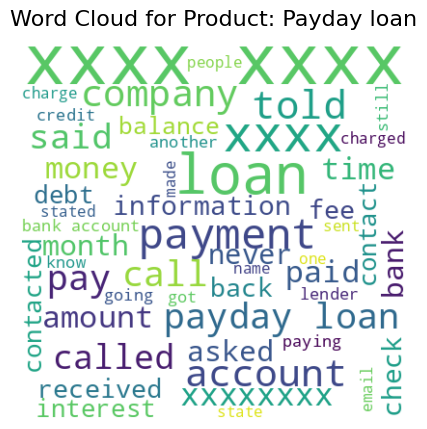

In [22]:
def wordcloud_for_product(df):
    products = df['product'].unique()
    print("Available products:\n")
    for i, prod in enumerate(products, 1):
        print(f"{i}. {prod}")

    choice = int(input("\nEnter the number corresponding to the product you want to see the word cloud for: "))
    selected_product = products[choice - 1]

    print(f"\nGenerating word cloud for: {selected_product}\n")

    text = ' '.join(df[df['product'] == selected_product]['cleaned_text'].dropna())

    wordcloud = WordCloud(
        width=400,
        height=400,
        background_color='white',
        stopwords=STOPWORDS,
        max_words=50,
        max_font_size=80,
        random_state=42
    ).generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"Word Cloud for Product: {selected_product}", fontsize=16)
    plt.axis('off')
    plt.show()

# Run this function with your dataframe containing 'cleaned_text'
wordcloud_for_product(df_narr)



**Why Word Clouds Often Disappoint in Financial NLP**
- Too many redacted placeholders like “xxx”, “xxxx”, or “name”.
- Generic words dominate, e.g. “account”, “bank”, “company” — words that appear in all complaints regardless of the issue.
- No differentiation by sentiment, so negative, positive, and neutral words are lumped together.
- Lack of context, like seeing the word “interest” but is it too high? too low? is unclear
- something visually cool but analytically shallow.

Better Alternatives - Instead of word clouds, consider - **Top Keywords by TF-IDF**
- gives distinguishing terms for a product or company that tells us what sets it apart from others.

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer

def top_keywords_by_product(df, product_name, max_features=20):
    subset = df[df['product'] == product_name]

    if subset.empty:
        print(f"No data available for product: {product_name}")
        return

    tfidf = TfidfVectorizer(max_features=max_features, stop_words='english')
    X = tfidf.fit_transform(subset['cleaned_text'].dropna())
    keywords = tfidf.get_feature_names_out()

    print(f"\nTop {max_features} TF-IDF keywords for '{product_name}':")
    for word in keywords:
        print(f" - {word}")


In [25]:
# View available product names
print(df_narr['product'].unique())

# Run the function with your choice
top_keywords_by_product(df_narr, "Credit card")


['Debt collection' 'Consumer Loan' 'Mortgage' 'Credit card'
 'Credit reporting' 'Student loan' 'Bank account or service' 'Payday loan'
 'Money transfers' 'Other financial service' 'Prepaid card']

Top 20 TF-IDF keywords for 'Credit card':
 - account
 - balance
 - bank
 - called
 - card
 - charge
 - credit
 - day
 - fee
 - late
 - month
 - paid
 - pay
 - payment
 - received
 - statement
 - time
 - told
 - xxxx
 - xxxxxxxx


Highlights complaint themes: The TF-IDF keywords like fee, charge, late, statement, and payment clearly point to billing, payment issues, and account disputes, which are common in credit card complaints.

Extracts real language from consumers: Unlike predefined categories, these are consumer-driven signals, revealing what people emphasize in their own words.

Helps summarize the focus of complaints for each product. But here's what's less useful: Generic words like called, told, and especially xxxx, xxxxxxxx — these aren't meaningful.

These placeholders (e.g., xxxx) are usually masked sensitive data and shouldn't appear as key features.

##5.  Concise Abstractive Summary (via NLP Model):

|Goal    |	Method	                 |Tool                      |
| ------ | ------------------------- |------------------------- |
|Coherent| short human-like summary  |	Abstractive	Transformers (e.g. BART, T5)|
|Real    |consumer sentences	Extractive |	Sumy (LSA, LexRank)|

In [30]:
from transformers import pipeline

# Step 1: Filter product
product = "Credit card"
subset = df_narr[df_narr['product'] == product]

# Step 2: Join all cleaned complaint narratives into one string
text_data = ' '.join(subset['cleaned_text'].dropna().tolist())

# Step 3: Use a summarization pipeline (e.g., distilbart or t5-small)
summarizer = pipeline("summarization", model="sshleifer/distilbart-cnn-12-6")

# Limit input size: summarizers can only handle ~1024-2048 tokens at a time
chunk = text_data[:2000]

# Step 4: Generate summary
summary = summarizer(chunk, max_length=100, min_length=30, do_sample=False)[0]['summary_text']
print(f"\n📝 Summary of complaints for '{product}':\n{summary}")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

Device set to use cpu



📝 Summary of complaints for 'Credit card':
 opened xxxx bank america credit card year ago interest account low time year ago got notice interest changing going prime plus thinkprime going back several bank option close account stay old term cond lock interest rate till paid offso new term cond acceptingi closed xxxx account made payment since time never latemy history show thisi month past year plus schedule payment online xxxx month get conformation number payment scheduledon xxxx xxxx .


In [ ]:
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.lsa import LsaSummarizer

# Text for the selected product
product = "Credit card"
subset = df_narr[df_narr['product'] == product]
text_data = '. '.join(subset['consumer_complaint_narrative'].dropna().tolist())

# Summarize using LSA
parser = PlaintextParser.from_string(text_data, Tokenizer("english"))
summarizer = LsaSummarizer()
summary_sentences = summarizer(parser.document, sentences_count=5)

print(f"\n📝 Extractive Summary of complaints for '{product}':\n")
for sentence in summary_sentences:
    print("–", sentence)


/usr/local/lib/python3.11/dist-packages/sumy/summarizers/lsa.py:76: UserWarning: Number of words (17940) is lower than number of sentences (85306). LSA algorithm may not work properly.
  warn(message % (words_count, sentences_count))


## Extras

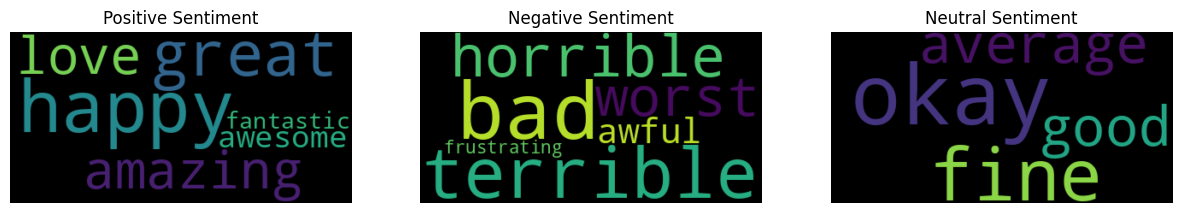

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Sample data: Positive, Negative, and Neutral reviews (text data)
positive_reviews = 'happy great amazing love awesome fantastic'
negative_reviews = 'bad terrible horrible worst awful frustrating'
neutral_reviews = 'okay fine average good'

# Generate word clouds
positive_wc = WordCloud().generate(positive_reviews)
negative_wc = WordCloud().generate(negative_reviews)
neutral_wc = WordCloud().generate(neutral_reviews)

# Plot word clouds
plt.figure(figsize=(15,5))
plt.subplot(1, 3, 1)
plt.imshow(positive_wc, interpolation='bilinear')
plt.title('Positive Sentiment')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(negative_wc, interpolation='bilinear')
plt.title('Negative Sentiment')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(neutral_wc, interpolation='bilinear')
plt.title('Neutral Sentiment')
plt.axis('off')

plt.show()


Confusion Matrix

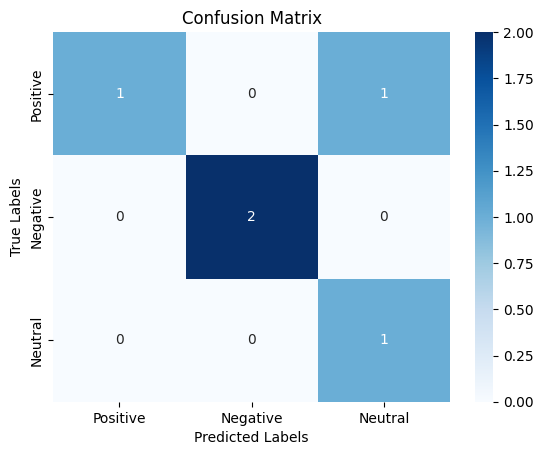

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Sample data: True labels and predicted labels
true_labels = ['positive', 'negative', 'positive', 'neutral', 'negative']
predicted_labels = ['positive', 'negative', 'neutral', 'neutral', 'negative']

cm = confusion_matrix(true_labels, predicted_labels, labels=['positive', 'negative', 'neutral'])

# Heatmap of confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Positive', 'Negative', 'Neutral'],
            yticklabels=['Positive', 'Negative', 'Neutral'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


Sentiment distribution (positive, negative, neutral) for each product or category

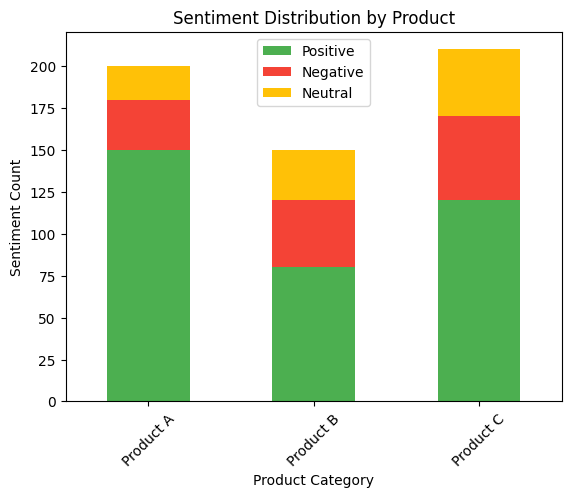

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Sample data: Categories and their sentiment counts
data = {'Category': ['Product A', 'Product B', 'Product C'],
        'Positive': [150, 80, 120],
        'Negative': [30, 40, 50],
        'Neutral': [20, 30, 40]}

df = pd.DataFrame(data)

# Plotting stacked bar graph
df.set_index('Category').plot(kind='bar', stacked=True, color=['#4CAF50', '#F44336', '#FFC107'])
plt.title('Sentiment Distribution by Product')
plt.xlabel('Product Category')
plt.ylabel('Sentiment Count')
plt.xticks(rotation=45)
plt.show()


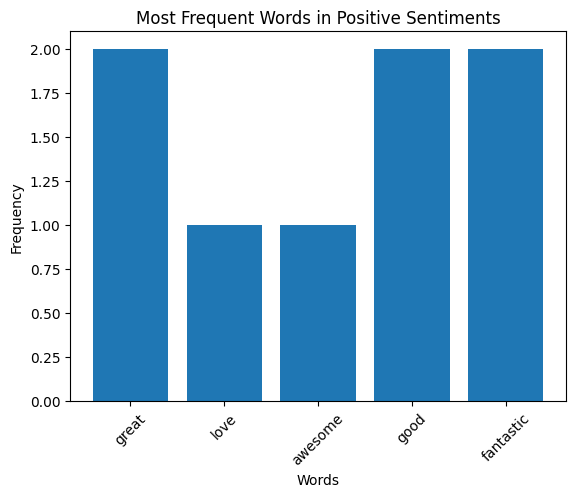

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt

# Example word frequencies for positive sentiment
positive_words = ['great', 'love', 'awesome', 'good', 'fantastic', 'great', 'good', 'fantastic']
word_counts = Counter(positive_words)

# Plotting bar chart for word frequencies
words, counts = zip(*word_counts.items())
plt.bar(words, counts)
plt.title('Most Frequent Words in Positive Sentiments')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()
